In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
from cassandra.cluster import Cluster

warnings.filterwarnings("ignore")

In [41]:
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()
session.set_keyspace('data') 
query = "SELECT * FROM farm_data"  
rows = session.execute(query)
cluster.shutdown()
df = pd.DataFrame(rows, columns=rows.column_names)
df.head(10)

,farm_id,crop_type,farm_area_acres,fertilizer_used_tons,irrigation_type,pesticide_used_kg,season,soil_type,water_usage_cubic_meters,yield_tons
0,F017,Carrot,284.01,5.89,Manual,0.81,Zaid,Loamy,88301.46,47.70
1,F002,Carrot,18.67,4.77,Manual,4.36,Kharif,Peaty,68725.54,42.91
2,F041,Rice,370.79,8.18,Flood,4.99,Kharif,Sandy,85208.71,35.01
3,F007,Soybean,360.06,1.83,Drip,2.37,Rabi,Sandy,40583.57,44.93
4,F047,Potato,347.66,3.86,Drip,2.68,Kharif,Sandy,86989.88,31.47
5,F032,Carrot,350.42,8.40,Flood,2.94,Rabi,Clay,71580.87,24.34
6,F018,Maize,128.23,4.91,Rain-fed,0.77,Rabi,Loamy,18660.03,16.67
7,F012,Sugarcane,145.32,3.01,Flood,2.27,Kharif,Clay,88976.51,8.08
8,F040,Cotton,166.82,2.85,Rain-fed,1.36,Zaid,Sandy,12007.70,46.19
9,F006,Sugarcane,12.50,6.42,Sprinkler,2.25,Zaid,Loamy,46487.98,38.18


In [ ]:
print("Shape of the dataset:", df.shape)
print("\nDataset Information:")
print(df.info())
print("\nSummary:")
display(df.describe().T)

Shape of the dataset: (50, 10)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   farm_id                   50 non-null     object 
 1   crop_type                 50 non-null     object 
 2   farm_area_acres           50 non-null     float64
 3   fertilizer_used_tons      50 non-null     float64
 4   irrigation_type           50 non-null     object 
 5   pesticide_used_kg         50 non-null     float64
 6   season                    50 non-null     object 
 7   soil_type                 50 non-null     object 
 8   water_usage_cubic_meters  50 non-null     float64
 9   yield_tons                50 non-null     float64
dtypes: float64(5), object(5)
memory usage: 4.0+ KB
None

Statistical Summary:


,count,mean,std,min,25%,50%,75%,max
farm_area_acres,50.0,254.9638,139.417782,12.50,135.7100,281.980,368.1075,483.88
fertilizer_used_tons,50.0,4.9054,2.732689,0.50,2.4375,5.045,6.8850,9.96
pesticide_used_kg,50.0,2.3980,1.438613,0.14,0.9725,2.330,3.4175,4.99
water_usage_cubic_meters,50.0,56724.2956,27264.992053,5869.75,37818.1525,54097.075,82240.0325,94754.73
yield_tons,50.0,27.0592,13.345789,3.86,16.1900,28.970,37.8600,48.02


In [ ]:
print(f'\nValeurs manquantes: {df.isna().sum().sum()}')
print(f'Valeurs dupliquees: {df.duplicated().sum()}')


Missing values: 0
Duplicated values: 0


In [ ]:
print("\nValeur unique par colonne:")
print(df.nunique())


Unique Values in Each Column:
farm_id                     50
crop_type                   10
farm_area_acres             50
fertilizer_used_tons        49
irrigation_type              5
pesticide_used_kg           46
season                       3
soil_type                    5
water_usage_cubic_meters    50
yield_tons                  50
dtype: int64


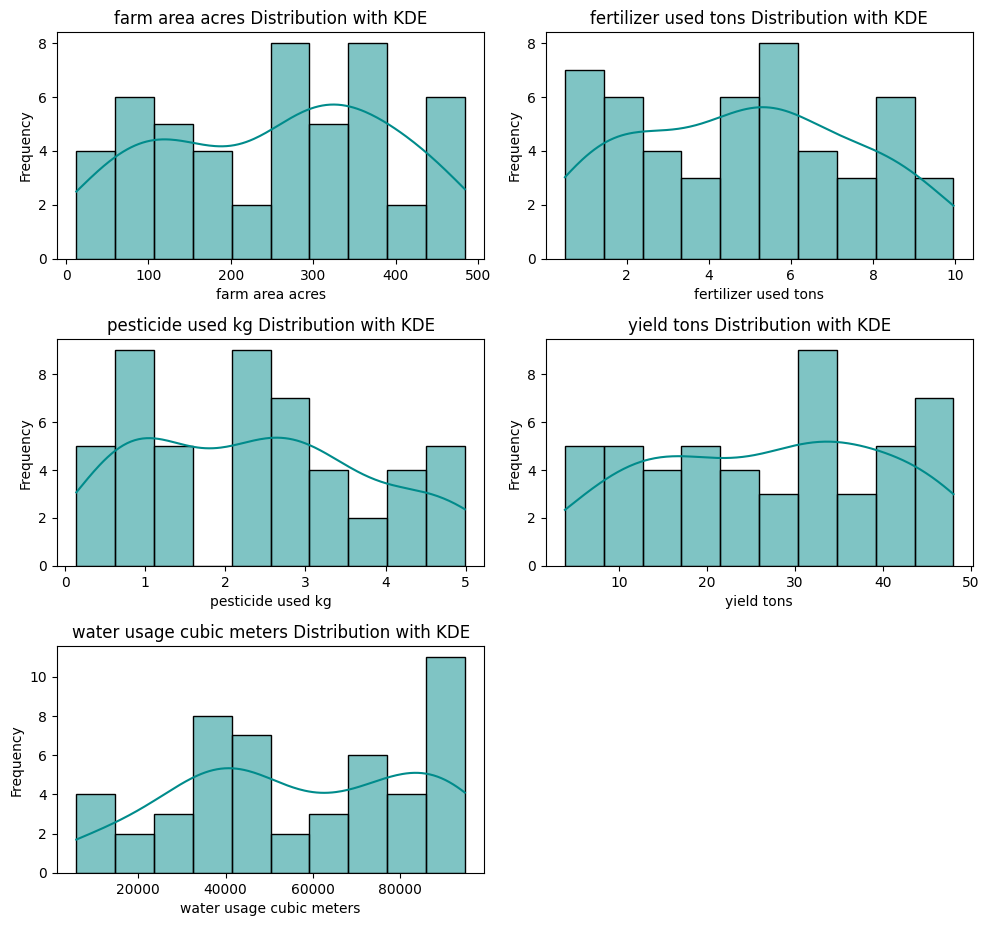

In [45]:
# Le KDE (Kernel Density Estimation) est une méthode utilisée pour estimer la densité de probabilité d'une variable continue.

def univariate_analysis(data, columns):
    plt.figure(figsize=(10, 12))  
    
    for i, column in enumerate(columns, 1):
        plt.subplot(4, 2, i)  
        sns.histplot(data[column], kde=True, bins=10, color='darkcyan')
        plt.title(f'{column.replace("_", " ")} Distribution with KDE')
        plt.xlabel(column.replace('_', ' '))
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

columns_to_analyze = ['farm_area_acres', 'fertilizer_used_tons', 'pesticide_used_kg', 'yield_tons', 'water_usage_cubic_meters']

univariate_analysis(df, columns_to_analyze)

# Analyse univariée des colonnes numériques :

Farm Area (acres) :
La distribution est relativement large, avec des superficies de fermes allant de petites à grandes parcelles. L'histogramme montre une légère asymétrie à droite, ce qui suggère que, bien que de nombreuses fermes aient des superficies modérées, certaines possèdent des terrains beaucoup plus vastes.

Fertilizer Used (tons) :
La distribution de l'utilisation des engrais présente un pic autour des valeurs moyennes, avec quelques fermes utilisant des quantités beaucoup plus élevées. Cela pourrait indiquer une plage courante d'exigences en engrais pour la majorité des fermes, avec seulement quelques valeurs extrêmes (outliers).

Pesticide Used (kg) :
L'utilisation des pesticides semble être asymétrique à gauche, avec de nombreuses fermes utilisant de faibles quantités, tandis qu'un petit nombre en consomme beaucoup plus.

Yield (tons) :
La distribution du rendement est légèrement asymétrique à droite, avec la majorité des fermes obtenant des rendements modérés, tandis que certaines réalisent des rendements beaucoup plus élevés. Cette dispersion pourrait être due à des variations de types de cultures, de taille de ferme ou d’efficacité des intrants.

Water Usage (cubic meters) :
L'utilisation de l'eau varie fortement et suit une distribution asymétrique à droite. Certaines fermes consomment beaucoup plus d'eau, probablement en raison des besoins spécifiques des cultures, des méthodes d’irrigation ou de la taille des exploitations.


In [46]:
def plot_categorical_distribution(column_name, data=df):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    sns.countplot(y=column_name, data=df, palette='muted')  
    plt.title(f'Distribution de {column_name}')
    
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2), 
                    ha='center', va='center', xytext=(10, 0), textcoords='offset points')
    
    sns.despine(left=True, bottom=True)
    
    plt.subplot(1, 2, 2)
    df[column_name].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('muted'), startangle=90, explode=[0.05]*df[column_name].nunique())
    plt.title(f'Pourcentage de distribution de {column_name}')
    plt.ylabel('')  
    
    plt.tight_layout()
    plt.show()

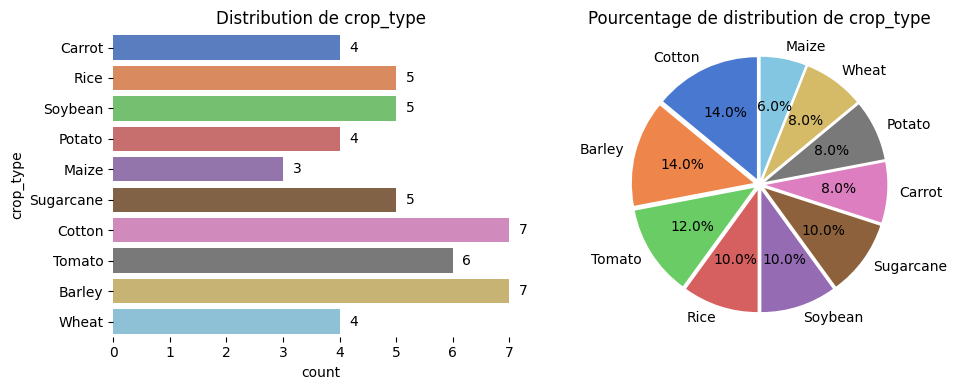

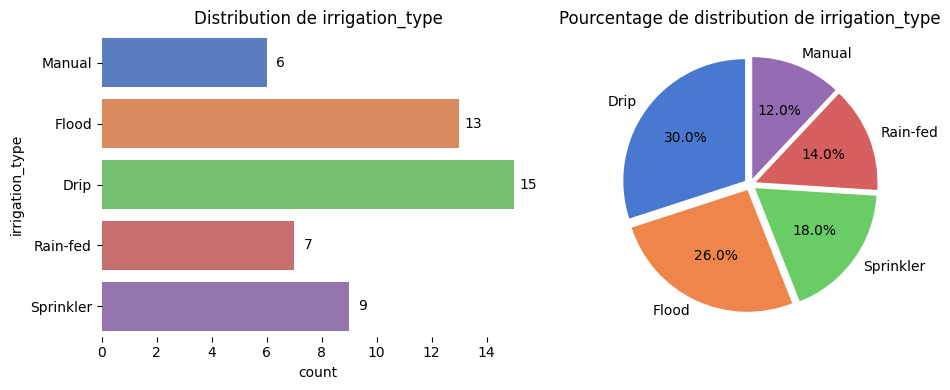

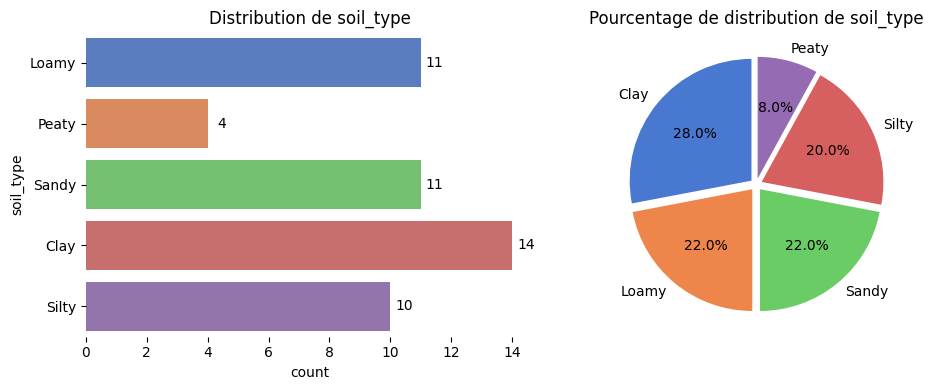

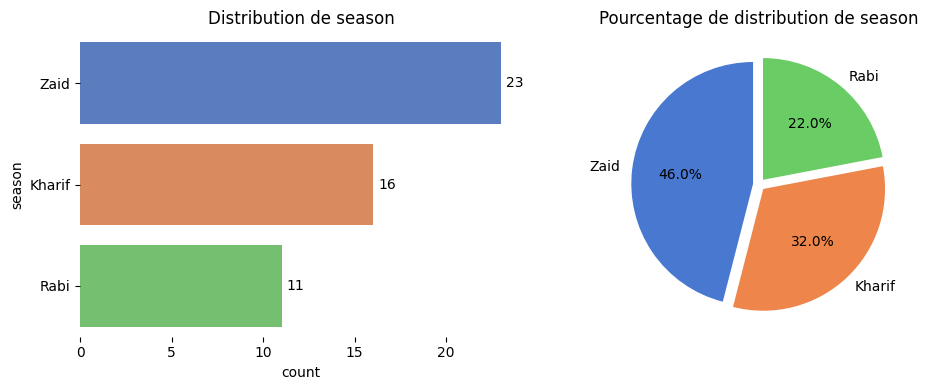

In [47]:
plot_categorical_distribution('crop_type')
plot_categorical_distribution('irrigation_type')
plot_categorical_distribution('soil_type')
plot_categorical_distribution('season')

Type de culture (Crop Type) :
Distribution : Le jeu de données inclut une variété de cultures, avec certaines cultures comme le coton, la carotte et la tomate apparaissant plus fréquemment. D'autres, comme la pomme de terre et l'orge, sont moins courantes.
Interprétation : La diversité des cultures suggère des besoins variés en ressources (eau, engrais, pesticides) et des rendements potentiellement différents en fonction du type de culture cultivé.

Type d'irrigation (Irrigation Type) :
Distribution : Les méthodes d'irrigation varient, mais les systèmes d'aspersion (Sprinkler) et manuels sont les plus répandus. Les méthodes goutte-à-goutte (Drip) et pluviales (Rain-fed) sont moins courantes.
Interprétation : La prédominance de l'irrigation manuelle et par aspersion peut influencer la consommation d'eau et d’engrais, car ces méthodes sont souvent moins efficaces que le goutte-à-goutte en termes de conservation des ressources.

Type de sol (Soil Type) :
Distribution : Il existe une représentation relativement équilibrée des types de sols, avec une prépondérance des sols limoneux (Loamy) et silteux (Silty), suivis des sols tourbeux (Peaty), argileux (Clay) et sableux (Sandy).
Interprétation : Cette répartition indique une grande diversité des conditions de sol, ce qui peut affecter le choix des cultures et leur potentiel de rendement.

Saison (Season) :
Distribution : La saison Kharif est la plus courante, suivie des saisons Zaid et Rabi.
Interprétation : La forte concentration des activités agricoles pendant la saison Kharif pourrait être liée aux cycles saisonniers des cultures et aux conditions climatiques favorables à cette période.


In [48]:
metrics_summary = {
    "metric": [
        "highest_yield", "lowest_yield",
        "highest_fertilizer_used", "lowest_fertilizer_used",
        "highest_pesticide_used", "lowest_pesticide_used",
        "highest_water_usage", "lowest_water_usage",
        "highest_farm_area", "lowest_farm_area"
    ],
    "crop_type": [
        df.loc[df['yield_tons'].idxmax()]['crop_type'], df.loc[df['yield_tons'].idxmin()]['crop_type'],
        df.loc[df['fertilizer_used_tons'].idxmax()]['crop_type'], df.loc[df['fertilizer_used_tons'].idxmin()]['crop_type'],
        df.loc[df['pesticide_used_kg'].idxmax()]['crop_type'], df.loc[df['pesticide_used_kg'].idxmin()]['crop_type'],
        df.loc[df['water_usage_cubic_meters'].idxmax()]['crop_type'], df.loc[df['water_usage_cubic_meters'].idxmin()]['crop_type'],
        df.loc[df['farm_area_acres'].idxmax()]['crop_type'], df.loc[df['farm_area_acres'].idxmin()]['crop_type']
    ],
    "value": [
        df.loc[df['yield_tons'].idxmax()]['yield_tons'], df.loc[df['yield_tons'].idxmin()]['yield_tons'],
        df.loc[df['fertilizer_used_tons'].idxmax()]['fertilizer_used_tons'], df.loc[df['fertilizer_used_tons'].idxmin()]['fertilizer_used_tons'],
        df.loc[df['pesticide_used_kg'].idxmax()]['pesticide_used_kg'], df.loc[df['pesticide_used_kg'].idxmin()]['pesticide_used_kg'],
        df.loc[df['water_usage_cubic_meters'].idxmax()]['water_usage_cubic_meters'], df.loc[df['water_usage_cubic_meters'].idxmin()]['water_usage_cubic_meters'],
        df.loc[df['farm_area_acres'].idxmax()]['farm_area_acres'], df.loc[df['farm_area_acres'].idxmin()]['farm_area_acres']
    ]
}

metrics_summary_df = pd.DataFrame(metrics_summary)
metrics_summary_df

,metric,crop_type,value
0,highest_yield,Tomato,48.02
1,lowest_yield,Maize,3.86
2,highest_fertilizer_used,Cotton,9.96
3,lowest_fertilizer_used,Cotton,0.50
4,highest_pesticide_used,Rice,4.99
5,lowest_pesticide_used,Barley,0.14
6,highest_water_usage,Cotton,94754.73
7,lowest_water_usage,Rice,5869.75
8,highest_farm_area,Rice,483.88
9,lowest_farm_area,Sugarcane,12.50


In [49]:
crop_farm_table = df.groupby('crop_type')['farm_id'].apply(list).reset_index()

crop_farm_table

,crop_type,farm_id
0,Barley,"[F049, F033, F016, F031, F038, F025, F020]"
1,Carrot,"[F017, F002, F032, F046]"
2,Cotton,"[F040, F027, F001, F036, F021, F043, F039]"
3,Maize,"[F018, F019, F009]"
4,Potato,"[F047, F030, F023, F048]"
5,Rice,"[F041, F014, F024, F008, F011]"
6,Soybean,"[F007, F010, F044, F035, F037]"
7,Sugarcane,"[F012, F006, F042, F003, F015]"
8,Tomato,"[F005, F004, F028, F034, F045, F050]"
9,Wheat,"[F026, F013, F029, F022]"


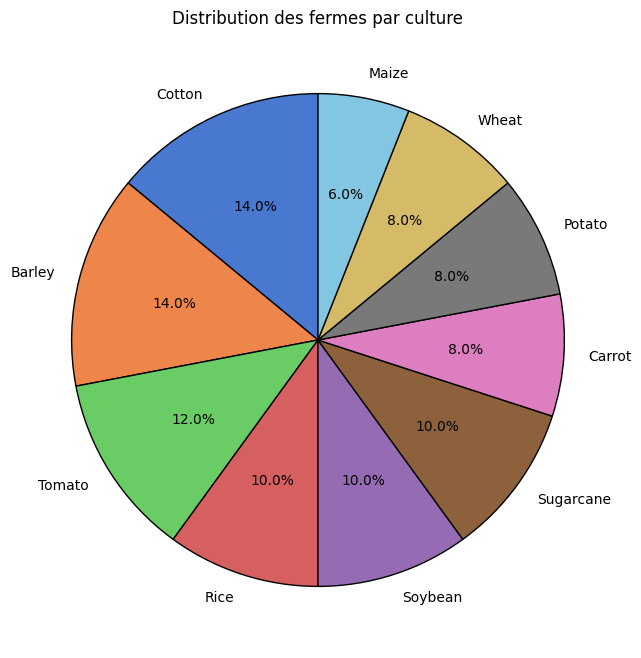

In [50]:
# Plotting the pie chart for farm distribution by crop type
plt.figure(figsize=(8, 8))
crop_type_counts = df['crop_type'].value_counts()
plt.pie(crop_type_counts, labels=crop_type_counts.index, autopct='%1.1f%%', startangle=90,
        colors=sns.color_palette('muted'), wedgeprops={'edgecolor': 'black'})

plt.title('Distribution des fermes par culture')
plt.show()

In [51]:
# Calculating the total area for each crop type
total_area_per_crop = df.groupby('crop_type')['farm_area_acres'].sum().reset_index()

total_area_per_crop

,crop_type,farm_area_acres
0,Barley,1671.22
1,Carrot,765.90
2,Cotton,1993.80
3,Maize,978.53
4,Potato,727.24
5,Rice,1845.24
6,Soybean,1050.68
7,Sugarcane,1187.99
8,Tomato,1655.02
9,Wheat,872.57


In [52]:
highest_fertilizer_per_crop_soil = df.groupby(['crop_type', 'soil_type'])['fertilizer_used_tons'].mean().reset_index()
max_fertilizer_per_crop = highest_fertilizer_per_crop_soil.loc[highest_fertilizer_per_crop_soil.groupby('crop_type')['fertilizer_used_tons'].idxmax()]

print("Type de sol avec la plus grande quantité d'engrais utilisée pour chaque type de culture :")
display(max_fertilizer_per_crop)

min_fertilizer_per_crop = highest_fertilizer_per_crop_soil.loc[highest_fertilizer_per_crop_soil.groupby('crop_type')['fertilizer_used_tons'].idxmin()]

print("\nType de sol avec la plus faible quantité d'engrais utilisée pour chaque type de culture :")
display(min_fertilizer_per_crop)

Type de sol avec la plus grande quantité d'engrais utilisée pour chaque type de culture :


,crop_type,soil_type,fertilizer_used_tons
1,Barley,Loamy,7.790
5,Carrot,Loamy,5.890
8,Cotton,Loamy,6.245
10,Maize,Loamy,4.910
13,Potato,Loamy,9.430
16,Rice,Clay,7.165
21,Soybean,Silty,8.570
23,Sugarcane,Loamy,6.420
26,Tomato,Clay,8.330
30,Wheat,Clay,6.105



Type de sol avec la plus faible quantité d'engrais utilisée pour chaque type de culture :


,crop_type,soil_type,fertilizer_used_tons
2,Barley,Sandy,2.900
6,Carrot,Peaty,4.770
9,Cotton,Sandy,2.100
11,Maize,Peaty,0.570
14,Potato,Sandy,3.860
17,Rice,Sandy,4.595
19,Soybean,Loamy,1.180
22,Sugarcane,Clay,1.895
27,Tomato,Loamy,4.750
32,Wheat,Silty,1.790


In [53]:
highest_pesticide_usage_per_crop_season = df.groupby(['crop_type', 'season'])['pesticide_used_kg'].mean().reset_index()
max_pesticide_usage_per_crop = highest_pesticide_usage_per_crop_season.loc[highest_pesticide_usage_per_crop_season.groupby('crop_type')['pesticide_used_kg'].idxmax()]

min_pesticide_usage_per_crop = highest_pesticide_usage_per_crop_season.loc[highest_pesticide_usage_per_crop_season.groupby('crop_type')['pesticide_used_kg'].idxmin()]

print("Saison avec le plus haut taux de pesticides utilise:")
display(max_pesticide_usage_per_crop)

print("\nSaison avec le plus bas taux de pesticipide utilise:")
display(min_pesticide_usage_per_crop)

Saison avec le plus haut taux de pesticides utilise:


,crop_type,season,pesticide_used_kg
0,Barley,Kharif,2.213333
3,Carrot,Rabi,2.940000
5,Cotton,Kharif,3.485000
8,Maize,Rabi,2.850000
10,Potato,Kharif,2.680000
13,Rice,Rabi,3.450000
17,Soybean,Zaid,2.890000
18,Sugarcane,Kharif,1.660000
22,Tomato,Zaid,4.415000
23,Wheat,Rabi,3.030000



Saison avec le plus bas taux de pesticipide utilise:


,crop_type,season,pesticide_used_kg
1,Barley,Zaid,1.560000
4,Carrot,Zaid,0.810000
6,Cotton,Rabi,0.910000
9,Maize,Zaid,1.310000
11,Potato,Zaid,2.253333
14,Rice,Zaid,1.765000
16,Soybean,Rabi,2.450000
19,Sugarcane,Zaid,1.415000
20,Tomato,Kharif,0.655000
24,Wheat,Zaid,2.805000


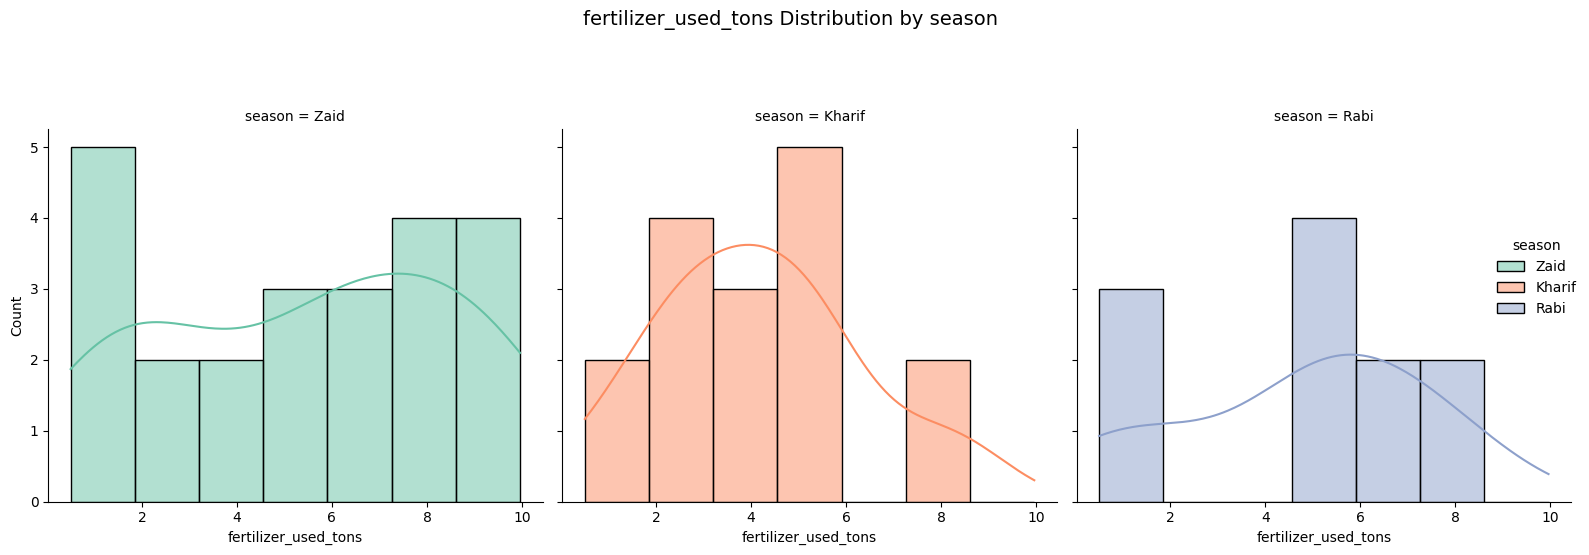

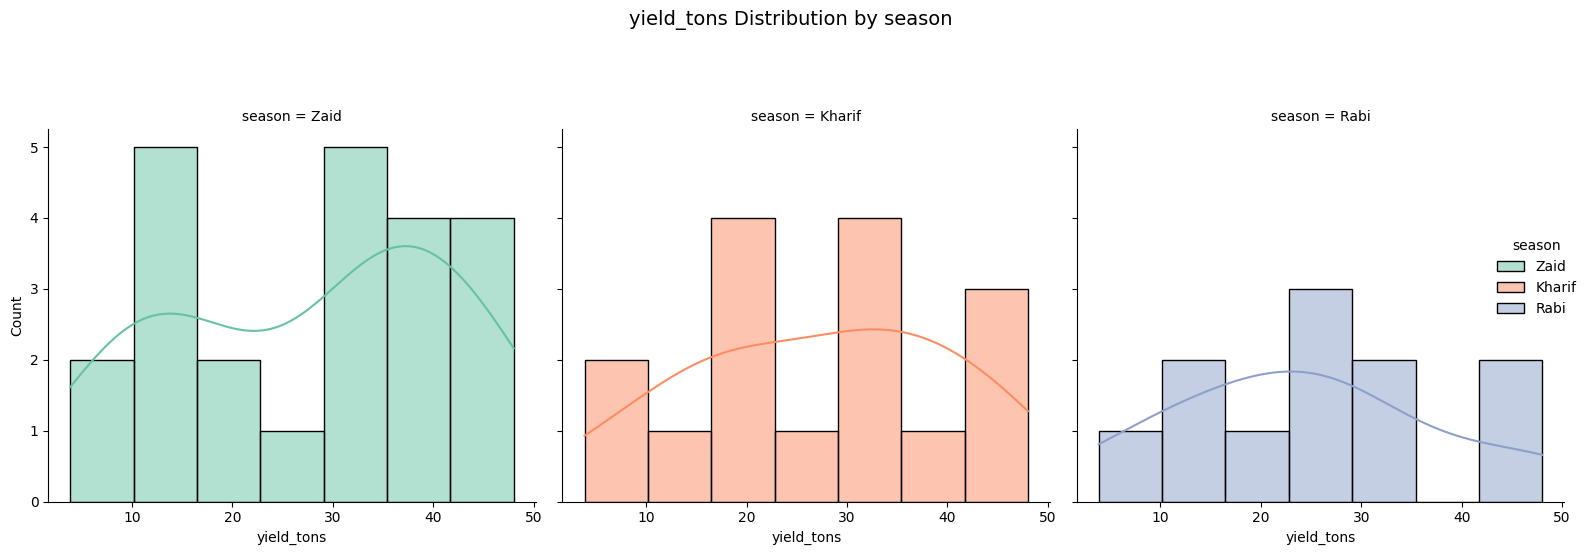

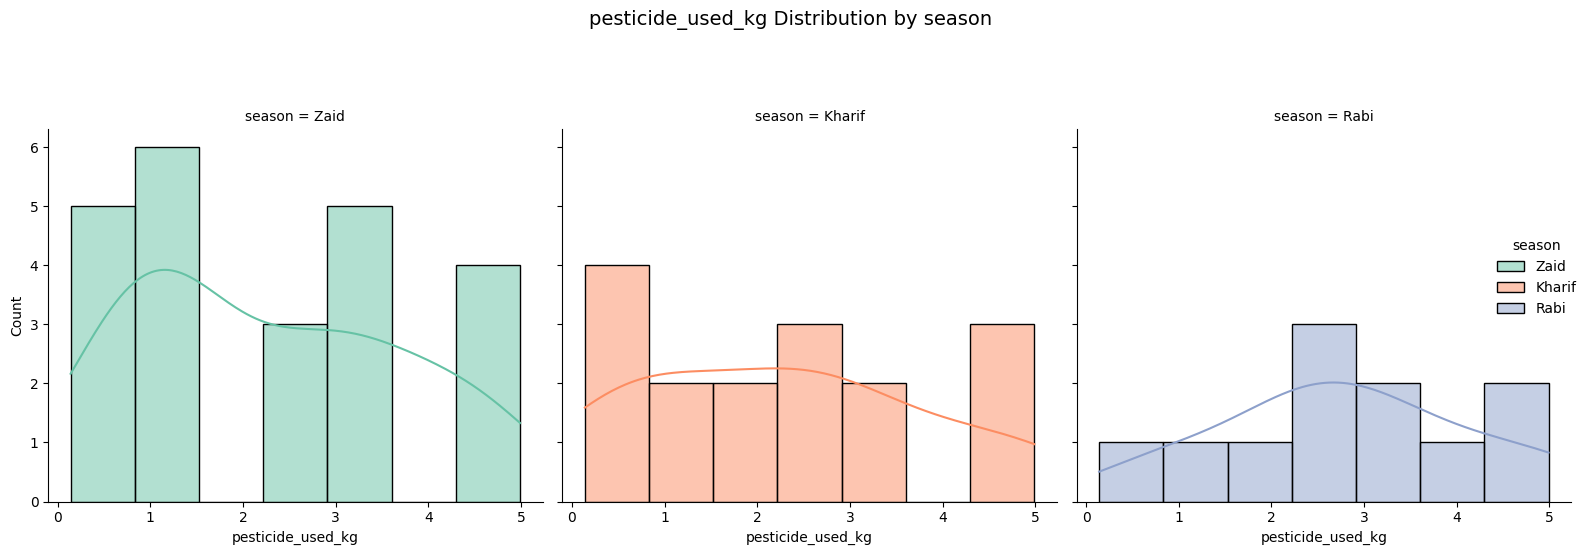

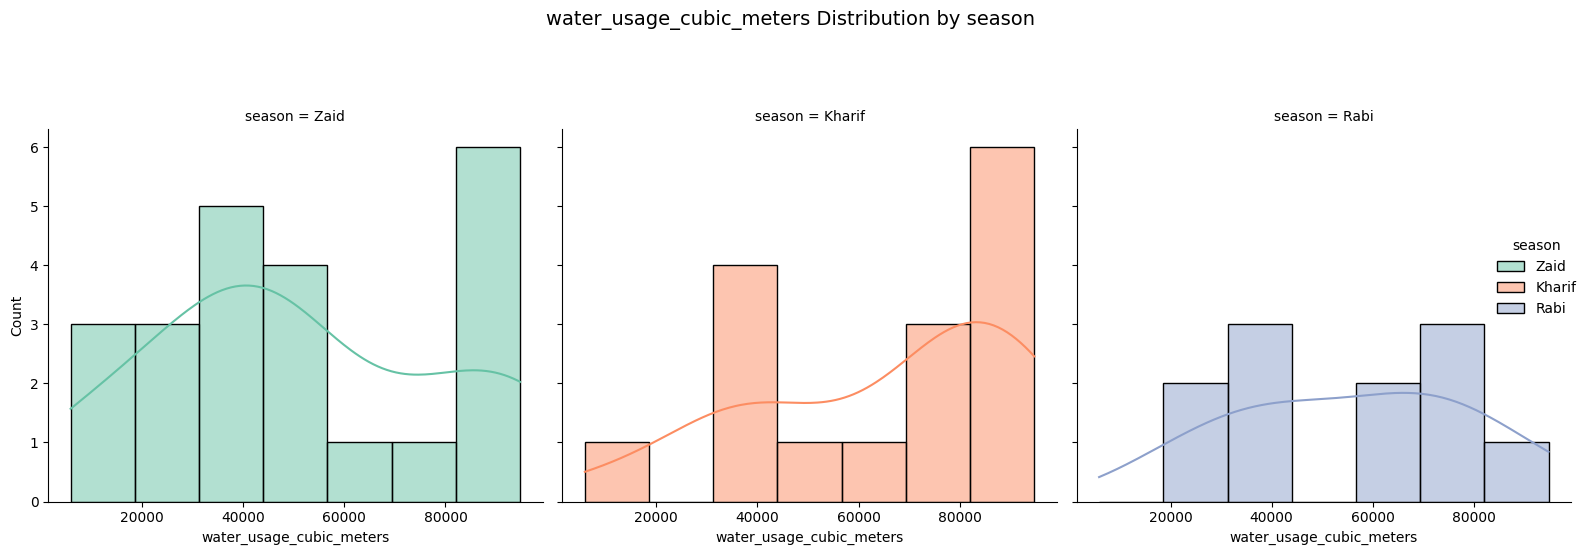

In [54]:
def create_displots_by_season(data, columns, col, hue, palette='Set2'):
    for column in columns:
        g = sns.displot(data=data, x=column, col=col, hue=hue, kde=True, palette=palette)
        g.fig.suptitle(f'{column} Distribution by {col}', fontsize=14, y=1.10)
        plt.tight_layout()
        plt.show()

# List of columns to create distribution plots for
columns_to_plot = ["fertilizer_used_tons", "yield_tons", "pesticide_used_kg", "water_usage_cubic_meters"]
create_displots_by_season(df, columns_to_plot, col='season', hue='season')

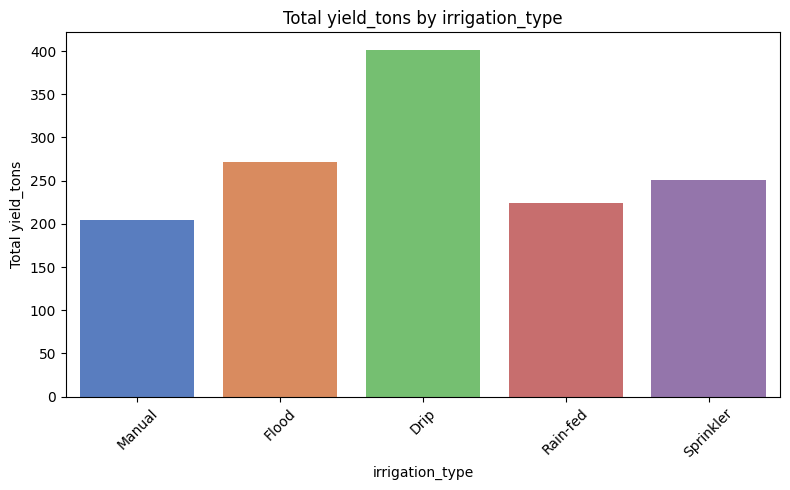

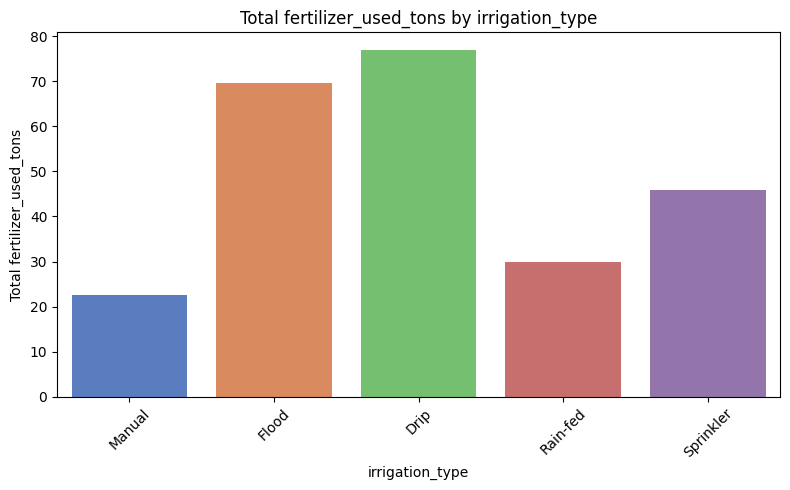

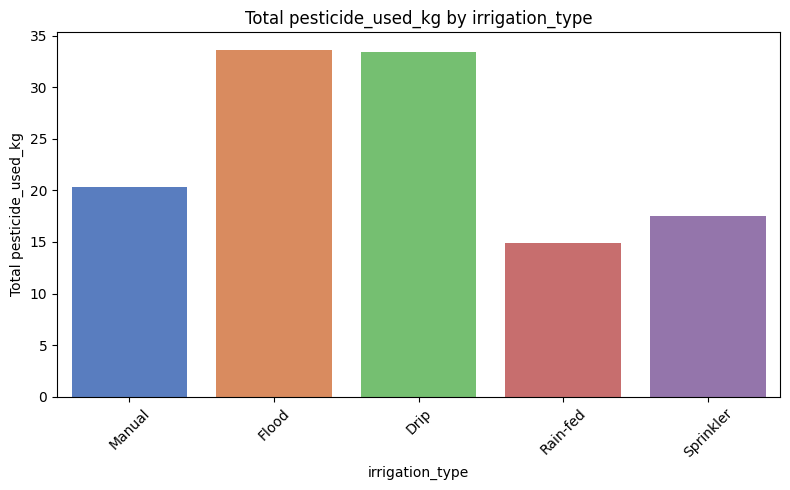

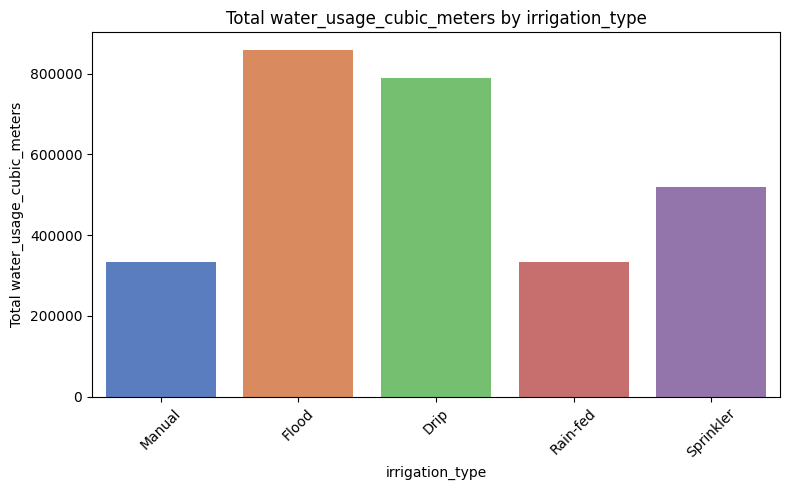

In [55]:
def create_bar_plots(data, x_column, y_columns, estimator=sum, ci=None, palette='muted'):
    for y_column in y_columns:
        plt.figure(figsize=(8, 5))
        sns.barplot(data=data, x=x_column, y=y_column, ci=ci, estimator=estimator, palette=palette)
        plt.title(f'Total {y_column} by {x_column}')
        plt.xlabel(x_column)
        plt.ylabel(f'Total {y_column}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# List of y_columns to create bar plots for
y_columns = ['yield_tons', 'fertilizer_used_tons', 'pesticide_used_kg', 'water_usage_cubic_meters']
create_bar_plots(df, 'irrigation_type', y_columns)

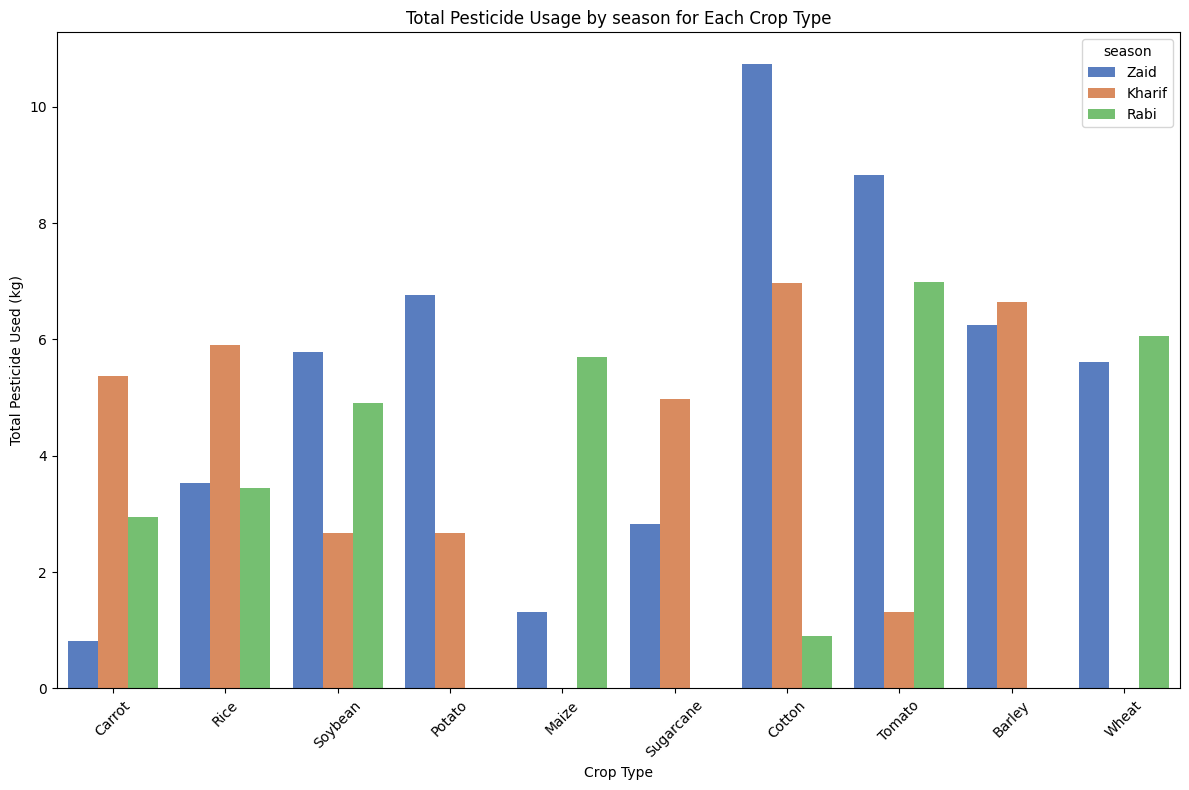

In [56]:
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='crop_type', y='pesticide_used_kg', hue='season', estimator=sum, ci=None, palette='muted')

plt.title('Total Pesticide Usage by season for Each Crop Type')
plt.xlabel('Crop Type')
plt.ylabel('Total Pesticide Used (kg)')
plt.xticks(rotation=45)
plt.legend(title='season')
plt.tight_layout()
plt.show()

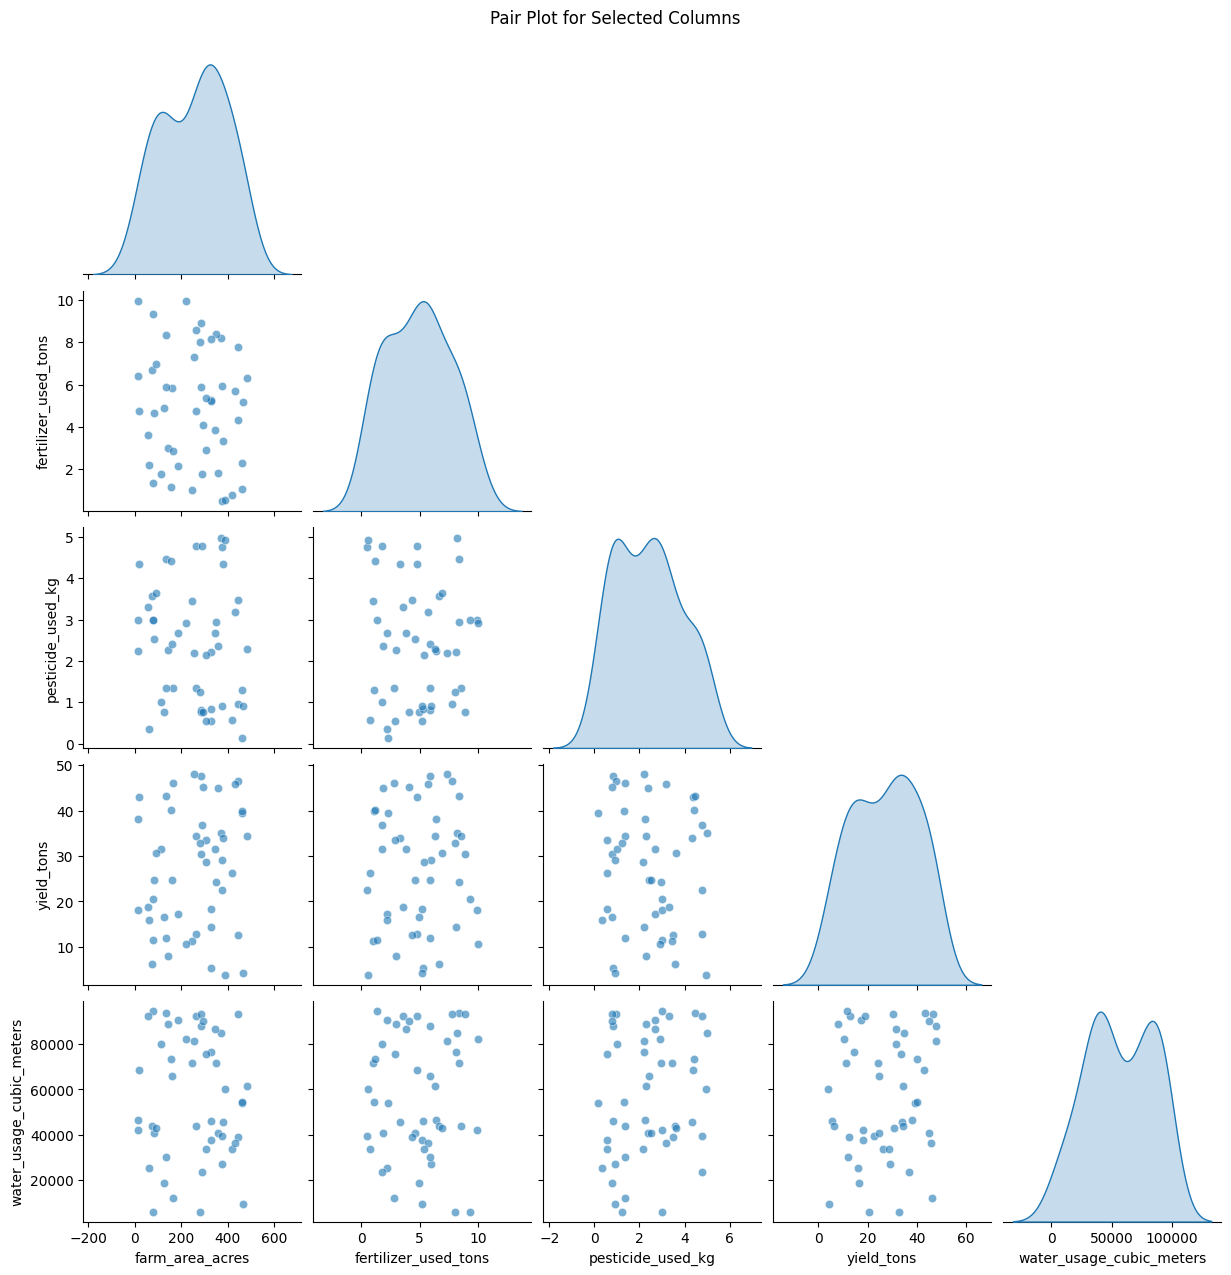

In [57]:
# Creating a pair plot for the specified columns
columns_to_pairplot = ['farm_area_acres', 'fertilizer_used_tons', 'pesticide_used_kg', 'yield_tons', 'water_usage_cubic_meters']

sns.pairplot(df[columns_to_pairplot], diag_kind='kde', corner=True, plot_kws={'alpha': 0.6})
plt.suptitle('Pair Plot for Selected Columns', y=1.02)
plt.show()

In [58]:
def encode_categorical_columns(df, columns):
    df_encoded = df.copy()
    
    # Initializing encoders
    label_encoder = LabelEncoder()
    one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # 'drop' reduces dimensionality by removing one category

    for col in columns:
        if col == 'farm_id':
            # Label Encoding for 'farm_id'
            df_encoded[col] = label_encoder.fit_transform(df_encoded[col])
        else:
            # One-Hot Encoding for other columns
            one_hot_encoded = pd.DataFrame(one_hot_encoder.fit_transform(df_encoded[[col]]), columns=[f"{col}_{cat}" for cat in one_hot_encoder.categories_[0][1:]])
            # Drop the original column and concatenate the new one-hot-encoded columns
            df_encoded = df_encoded.drop(col, axis=1).join(one_hot_encoded)

    return df_encoded

categorical_columns = ['farm_id', 'crop_type', 'irrigation_type', 'soil_type', 'season']
df_encoded = encode_categorical_columns(df, categorical_columns)

df_encoded.head()

,farm_id,farm_area_acres,fertilizer_used_tons,pesticide_used_kg,water_usage_cubic_meters,yield_tons,crop_type_Carrot,crop_type_Cotton,crop_type_Maize,crop_type_Potato,...,irrigation_type_Flood,irrigation_type_Manual,irrigation_type_Rain-fed,irrigation_type_Sprinkler,soil_type_Loamy,soil_type_Peaty,soil_type_Sandy,soil_type_Silty,season_Rabi,season_Zaid
0,16,284.01,5.89,0.81,88301.46,47.70,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,18.67,4.77,4.36,68725.54,42.91,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,40,370.79,8.18,4.99,85208.71,35.01,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,6,360.06,1.83,2.37,40583.57,44.93,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,46,347.66,3.86,2.68,86989.88,31.47,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


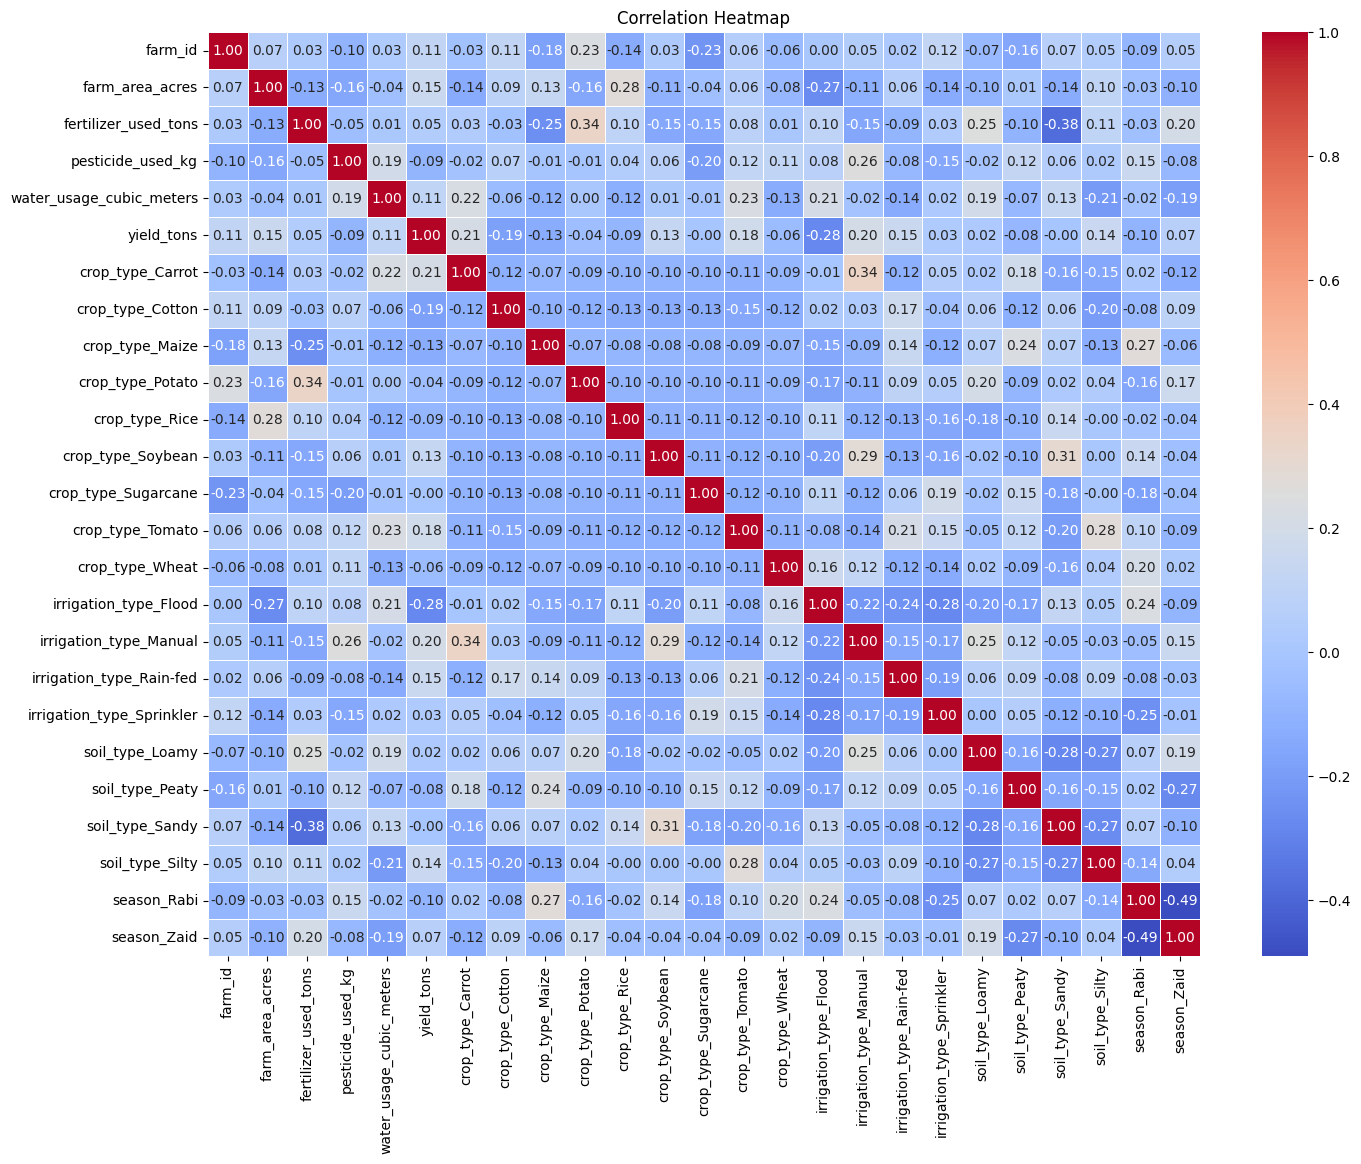

In [59]:
corr_matrix = df_encoded.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Corrélation avec le rendement (Yield - tons) :
📌 Facteurs influençant le rendement :
Superficie des fermes (Farm_Area_acres) : Corrélation positive mais faible (0.15). Les grandes exploitations ont tendance à produire légèrement plus, mais cette relation reste marginale.
Engrais utilisés (Fertilizer_Used_tons) : Corrélation positive mais très faible (0.045). L’engrais joue un rôle, mais d’autres facteurs influencent davantage le rendement.
Consommation d’eau (Water_Usage_cubic_meters) : Corrélation positive (0.11). Une meilleure disponibilité en eau améliore légèrement les rendements, ce qui est logique car l’eau est essentielle à la croissance des cultures.
Type de culture (Crop_Type) :
Carotte (0.21) et Tomate (0.18) ont les meilleures corrélations positives avec le rendement, suggérant que ces cultures ont un potentiel de productivité élevé.
Coton (-0.19) a une corrélation négative, ce qui peut indiquer des rendements plus faibles par rapport aux autres cultures.
📌 Relation entre les intrants agricoles :
Engrais vs Pesticides (-0.045) : Corrélation très faible et négative, ce qui suggère que ces deux intrants ne sont pas directement liés et varient selon les besoins spécifiques des cultures.
Engrais vs Eau (0.012) : Corrélation positive mais insignifiante, indiquant que l’utilisation de plus d’engrais peut coïncider avec une consommation accrue d’eau, mais sans lien fort.
Superficie vs Eau (-0.04) : Corrélation négative faible, montrant que les grandes exploitations n’utilisent pas nécessairement plus d’eau par hectare, probablement en raison de méthodes d’irrigation optimisées.
Superficie vs Engrais (-0.13) : Corrélation négative faible, ce qui suggère que les grandes fermes utilisent légèrement moins d’engrais par hectare, ce qui peut refléter une gestion plus extensive des cultures.
📌 Influence du type de sol et de la saison :
Sol limoneux (Loamy Soil) et Yield (0.02) : Corrélation légèrement positive, confirmant que le sol limoneux est favorable aux rendements grâce à ses bonnes capacités de rétention d’eau et de nutriments.
Saison Kharif et Yield : Corrélation positive, indiquant que les cultures de saison Kharif ont tendance à produire de meilleurs rendements, probablement grâce aux conditions climatiques plus favorables.
📌 Effets du type d’irrigation sur le rendement :
Irrigation manuelle et Yield (0.19) : Corrélation modérée et positive, suggérant que les fermes utilisant une irrigation manuelle peuvent obtenir de meilleurs rendements, soit en se concentrant sur des cultures à haut rendement, soit grâce à une gestion plus ciblée de l’eau.
Irrigation par inondation (Flood Irrigation) et Yield (-0.27) : Corrélation négative, ce qui peut s’expliquer par une moins bonne efficacité de cette méthode, menant parfois à un gaspillage d’eau ou à un engorgement des sols.
📌 Observations spécifiques aux cultures :
Le coton (-0.19) et Yield : Les cultures de coton semblent produire des rendements plus faibles, ce qui peut être dû à des cycles de croissance plus longs ou à des besoins spécifiques.
La pomme de terre (0.34) et Engrais : Corrélation fortement positive, indiquant que la culture de pommes de terre nécessite des apports en engrais plus élevés pour maintenir une productivité optimale.


In [60]:
X = df_encoded.drop(columns=['yield_tons'])  # Features
y = df_encoded['yield_tons']  # Target

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store models and results
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, use_label_encoder=False, eval_metric='rmse'),
    'LGBM': LGBMRegressor(verbose=-1, random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42)
}

results = {}

# Training and evaluating each model
for model_name, model in models.items():
    # Training
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'MSE': mse, 'R2': r2}
    
    print(f"{model_name} - MSE: {mse:.2f}, R2: {r2:.2f}")

Linear Regression - MSE: 584.93, R2: -3.95
Random Forest - MSE: 149.90, R2: -0.27
XGBoost - MSE: 207.37, R2: -0.75
LGBM - MSE: 118.18, R2: 0.00
CatBoost - MSE: 127.82, R2: -0.08


In [61]:
best_model = min(results, key=lambda x: results[x]['MSE'])
print(f"The best model is: {best_model} with MSE: {results[best_model]['MSE']:.2f} and R2: {results[best_model]['R2']:.2f}")

The best model is: LGBM with MSE: 118.18 and R2: 0.00
